In [95]:
num_clients = 100
distribution_type = 'non_iid'  
root_percentage = 0.1  
root_client = True


# Split into Dist

In [96]:
import os
import struct
import numpy as np
from sklearn.model_selection import train_test_split

def LoadMNIST(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))  # Unused magic number and count
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        struct.unpack('>IIII', imgpath.read(16))  # Unused magic number and dimensions
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

mnist_path = 'mnist'
x_train, y_train = LoadMNIST(mnist_path, kind='train')
x_test, y_test = LoadMNIST(mnist_path, kind='t10k')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=10000, random_state=42)
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Training data:", x_train.shape, y_train.shape)
print("Validation data:", x_valid.shape, y_valid.shape)
print("Test data:", x_test.shape, y_test.shape)


Training data: (50000, 28, 28, 1) (50000,)
Validation data: (10000, 28, 28, 1) (10000,)
Test data: (10000, 28, 28, 1) (10000,)


Root Data samples
[ 8 29 30 20 23  5  0  0 25 40]
Root Client assigned: 98


/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/1722090128.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/1722090128.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


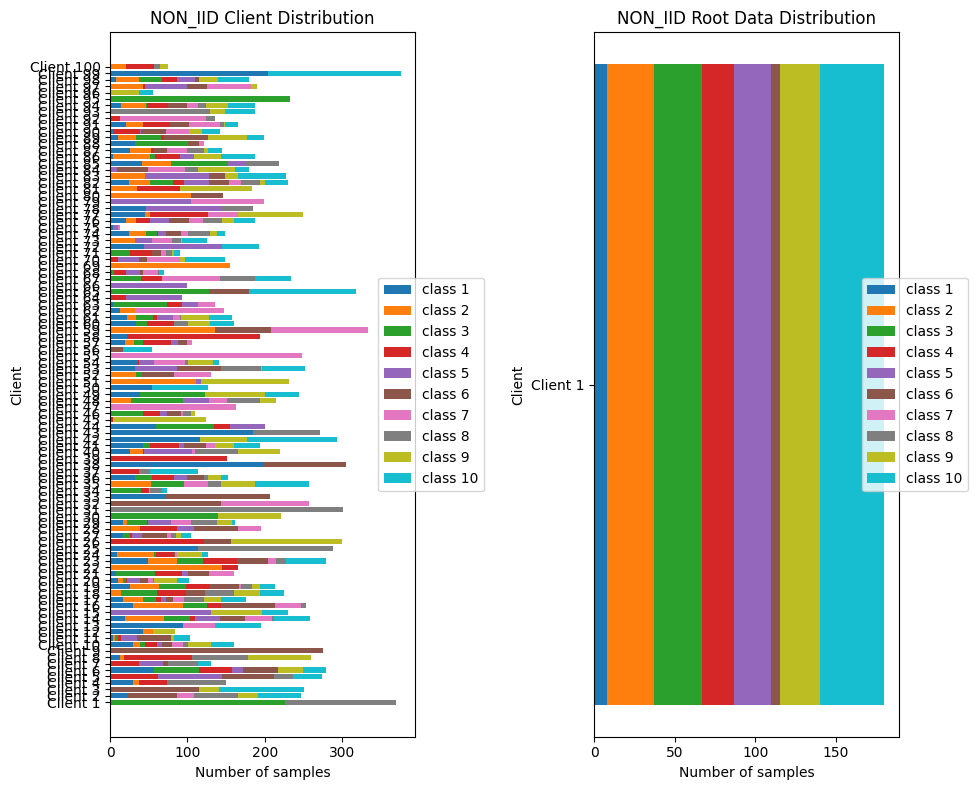

Root Data: 10 samples
[ 8 29 30 20 23  5  0  0 25 40]


In [99]:
import os
import numpy as np
import random

class FederatedDataSplitter:
    def __init__(self, x_train, y_train, x_test, y_test, num_clients=10, distribution='iid', dataset_dir='dataset', root_client=False, root_percentage=0.1):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_clients = num_clients
        self.distribution = distribution
        self.dataset_dir = dataset_dir
        self.root_client = root_client
        self.client_distributions = []
        self.root_distribution = []
        self.root_percentage = root_percentage

    def SplitData(self):
        os.makedirs(self.dataset_dir, exist_ok=True)
        client_data = []

        if self.distribution == 'iid':
            self.IIDSplit(client_data)
        else:
            self.NonIIDSplit(client_data)

        if self.root_client:
            self.AssignRootData(client_data)
        else:
            self.AssignRootDataAsSubset()

        self.SaveTestData()

    def IIDSplit(self, client_data):
        x_train_clients = self.x_train
        y_train_clients = self.y_train
        split_sizes = [len(x_train_clients) // self.num_clients] * self.num_clients
        if sum(split_sizes) != len(x_train_clients):
            split_sizes[-1] += len(x_train_clients) - sum(split_sizes)

        start_idx = 0
        for i in range(self.num_clients):
            end_idx = start_idx + split_sizes[i]
            x_client = x_train_clients[start_idx:end_idx]
            y_client = y_train_clients[start_idx:end_idx]
            start_idx = end_idx

            client_data.append((x_client, y_client))
            self.SaveClientData(x_client, y_client, client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def NonIIDSplit(self, client_data):
        total_samples = len(self.x_train)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        classes = np.unique(self.y_train)

        for i in range(self.num_clients):
            num_samples = random.randint(total_samples // (self.num_clients * 2), total_samples // self.num_clients)
            x_client, y_client = [], []
            selected_classes = np.random.choice(classes, size=random.randint(1, len(classes)), replace=False)

            for cls in selected_classes:
                class_indices = indices[self.y_train[indices] == cls]
                num_class_samples = random.randint(1, num_samples // len(selected_classes))
                chosen_indices = np.random.choice(class_indices, size=min(num_class_samples, len(class_indices)), replace=False)
                x_client.extend(self.x_train[chosen_indices])
                y_client.extend(self.y_train[chosen_indices])

            client_data.append((np.array(x_client), np.array(y_client)))
            self.SaveClientData(np.array(x_client), np.array(y_client), client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def AssignRootDataAsSubset(self):
        total_samples = int(len(self.x_train) * self.root_percentage)
        indices = np.random.choice(len(self.x_train), size=total_samples, replace=False)
        x_root = self.x_train[indices]
        y_root = self.y_train[indices]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)

    def AssignRootData(self, client_data):
        random_client_id = np.random.randint(0, self.num_clients)
        x_root, y_root = client_data[random_client_id]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)
        print(f'Root Client assigned: {random_client_id + 1}')

    def SaveClientData(self, x_client, y_client, client_id):
        client_dir = os.path.join(self.dataset_dir, f'client_{client_id}')
        os.makedirs(client_dir, exist_ok=True)
        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

    def SaveTestData(self):
        test_dir = os.path.join(self.dataset_dir, 'test')
        os.makedirs(test_dir, exist_ok=True)
        np.save(os.path.join(test_dir, 'x_test.npy'), self.x_test)
        np.save(os.path.join(test_dir, 'y_test.npy'), self.y_test)

    def SaveRootData(self, x_root, y_root):
        root_dir = os.path.join(self.dataset_dir, 'root')
        os.makedirs(root_dir, exist_ok=True)
        np.save(os.path.join(root_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(root_dir, 'y_data.npy'), y_root)
        print(f'Root Data samples')
        print(np.bincount(y_root, minlength=10))


    @staticmethod
    def PlotDistributions(client_dist, root_dist, num_clients, title, root_client=False, root_assigned_client=None):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        FederatedDataSplitter.PlotSampleStats(client_dist, num_clients, root_client=root_client, root_assigned_client=root_assigned_client)
        plt.title(f'{title} Client Distribution')
        if not root_client:
            plt.subplot(1, 2, 2)
            FederatedDataSplitter.PlotSampleStats([root_dist], 1)
            plt.title(f'{title} Root Data Distribution')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def PlotSampleStats(dist, num_clients, root_client=False, root_assigned_client=None):
        colors = plt.cm.get_cmap('tab10')
        if num_clients == 1:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = 0
            for i in range(len(classes)):
                plt.barh(0, dist[0][i], left=left, color=colors(i), label=classes[i])
                left += dist[0][i]
        else:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = np.zeros(num_clients)
            for i in range(len(classes)):
                plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)],
                         left=left, color=colors(i), label=classes[i])
                left += [dist[j][i] for j in range(num_clients)]
            if root_client and root_assigned_client is not None:
                plt.barh(root_assigned_client - 1, sum(dist[root_assigned_client - 1]), color='red', alpha=0.3, label="Root Client")
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i + 1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')


splitter = FederatedDataSplitter(x_train, y_train, x_test, y_test,
                                  num_clients=num_clients, 
                                  dataset_dir='dataset',
                                  distribution=distribution_type,
                                  root_client=root_client,
                                  root_percentage=root_percentage)

splitter.SplitData()
splitter.PlotDistributions(splitter.client_distributions, splitter.root_distribution, splitter.num_clients, splitter.distribution.upper())
#Print number of samples and number of samples per class in root data
print(f'Root Data: {len(splitter.root_distribution)} samples')
print(splitter.root_distribution)



# CIFAR

In [5]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

def LoadBatch(path, batch_name):
    with open(os.path.join(path, batch_name), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        data = dict[b'data']
        labels = dict[b'labels']
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (num_samples, 32, 32, 3)
    return data, np.array(labels)

def LoadCIFAR(path):
    x_train, y_train = [], []
    for i in range(1, 6):
        data, labels = LoadBatch(path, f'data_batch_{i}')
        x_train.append(data)
        y_train.append(labels)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_test, y_test = LoadBatch(path, 'test_batch')
    
    return x_train, y_train, x_test, y_test

cifar_path = '/Users/lava/Documents/Codes/Federated/FLTrust/data/cifar-10-batches-py'
x_train, y_train, x_test, y_test = LoadCIFAR(cifar_path)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=10000, random_state=42)

print("Training data:", x_train.shape, y_train.shape)
print("Validation data:", x_valid.shape, y_valid.shape)
print("Test data:", x_test.shape, y_test.shape)


Training data: (40000, 32, 32, 3) (40000,)
Validation data: (10000, 32, 32, 3) (10000,)
Test data: (10000, 32, 32, 3) (10000,)


Root Data: 4000 samples
[404 401 362 415 412 420 392 398 389 407]


/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_15875/1859099593.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_15875/1859099593.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


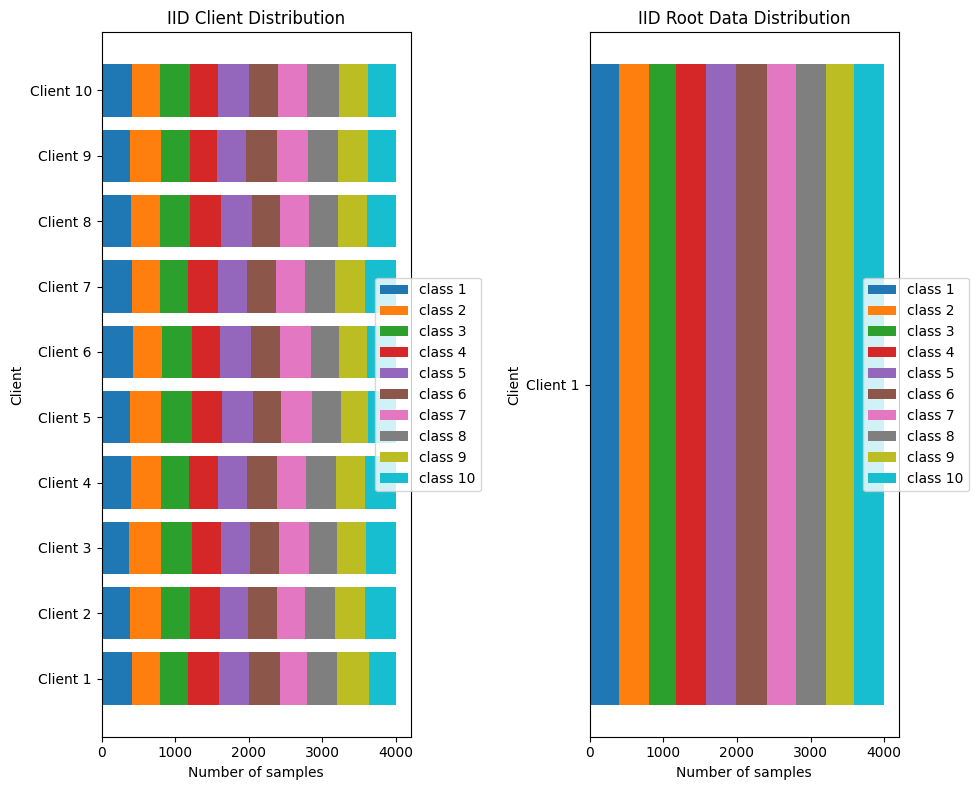

Root Data: 10 samples
[404 401 362 415 412 420 392 398 389 407]


In [6]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

class FederatedDataSplitter:
    def __init__(self, x_train, y_train, x_test, y_test, num_clients=10, distribution='iid', dataset_dir='dataset', root_client=False, root_percentage=0.1):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_clients = num_clients
        self.distribution = distribution
        self.dataset_dir = dataset_dir
        self.root_client = root_client
        self.client_distributions = []
        self.root_distribution = []
        self.root_percentage = root_percentage

    def SplitData(self):
        os.makedirs(self.dataset_dir, exist_ok=True)
        client_data = []

        if self.distribution == 'iid':
            self.IIDSplit(client_data)
        else:
            self.NonIIDSplit(client_data)

        if self.root_client:
            self.AssignRootData(client_data)
        else:
            self.AssignRootDataAsSubset()

        self.SaveTestData()

    def IIDSplit(self, client_data):
        x_train_clients = self.x_train
        y_train_clients = self.y_train
        split_sizes = [len(x_train_clients) // self.num_clients] * self.num_clients
        if sum(split_sizes) != len(x_train_clients):
            split_sizes[-1] += len(x_train_clients) - sum(split_sizes)

        start_idx = 0
        for i in range(self.num_clients):
            end_idx = start_idx + split_sizes[i]
            x_client = x_train_clients[start_idx:end_idx]
            y_client = y_train_clients[start_idx:end_idx]
            start_idx = end_idx

            client_data.append((x_client, y_client))
            self.SaveClientData(x_client, y_client, client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def NonIIDSplit(self, client_data):
        total_samples = len(self.x_train)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        classes = np.unique(self.y_train)

        for i in range(self.num_clients):
            num_samples = random.randint(total_samples // (self.num_clients * 2), total_samples // self.num_clients)
            x_client, y_client = [], []
            selected_classes = np.random.choice(classes, size=random.randint(1, len(classes)), replace=False)

            for cls in selected_classes:
                class_indices = indices[self.y_train[indices] == cls]
                num_class_samples = random.randint(1, num_samples // len(selected_classes))
                chosen_indices = np.random.choice(class_indices, size=min(num_class_samples, len(class_indices)), replace=False)
                x_client.extend(self.x_train[chosen_indices])
                y_client.extend(self.y_train[chosen_indices])

            client_data.append((np.array(x_client), np.array(y_client)))
            self.SaveClientData(np.array(x_client), np.array(y_client), client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def AssignRootDataAsSubset(self):
        total_samples = int(len(self.x_train) * self.root_percentage)
        indices = np.random.choice(len(self.x_train), size=total_samples, replace=False)
        x_root = self.x_train[indices]
        y_root = self.y_train[indices]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)

    def AssignRootData(self, client_data):
        random_client_id = np.random.randint(0, self.num_clients)
        x_root, y_root = client_data[random_client_id]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)
        print(f'Root Client assigned: {random_client_id + 1}')

    def SaveClientData(self, x_client, y_client, client_id):
        client_dir = os.path.join(self.dataset_dir, f'client_{client_id}')
        os.makedirs(client_dir, exist_ok=True)
        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

    def SaveTestData(self):
        test_dir = os.path.join(self.dataset_dir, 'test')
        os.makedirs(test_dir, exist_ok=True)
        np.save(os.path.join(test_dir, 'x_test.npy'), self.x_test)
        np.save(os.path.join(test_dir, 'y_test.npy'), self.y_test)

    def SaveRootData(self, x_root, y_root):
        root_dir = os.path.join(self.dataset_dir, 'root')
        os.makedirs(root_dir, exist_ok=True)
        np.save(os.path.join(root_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(root_dir, 'y_data.npy'), y_root)
        print(f'Root Data: {len(x_root)} samples')
        print(np.bincount(y_root, minlength=10))

    @staticmethod
    def PlotDistributions(client_dist, root_dist, num_clients, title, root_client=False, root_assigned_client=None):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        FederatedDataSplitter.PlotSampleStats(client_dist, num_clients, root_client=root_client, root_assigned_client=root_assigned_client)
        plt.title(f'{title} Client Distribution')
        if not root_client:
            plt.subplot(1, 2, 2)
            FederatedDataSplitter.PlotSampleStats([root_dist], 1)
            plt.title(f'{title} Root Data Distribution')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def PlotSampleStats(dist, num_clients, root_client=False, root_assigned_client=None):
        colors = plt.cm.get_cmap('tab10')
        if num_clients == 1:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = 0
            for i in range(len(classes)):
                plt.barh(0, dist[0][i], left=left, color=colors(i), label=classes[i])
                left += dist[0][i]
        else:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = np.zeros(num_clients)
            for i in range(len(classes)):
                plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)],
                         left=left, color=colors(i), label=classes[i])
                left += [dist[j][i] for j in range(num_clients)]
            if root_client and root_assigned_client is not None:
                plt.barh(root_assigned_client - 1, sum(dist[root_assigned_client - 1]), color='red', alpha=0.3, label="Root Client")
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i + 1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')


# Example usage with CIFAR-10 data
splitter = FederatedDataSplitter(x_train, y_train, x_test, y_test,
                                  num_clients=10, 
                                  dataset_dir='dataset',
                                  distribution='iid',
                                  root_client=False)

splitter.SplitData()
splitter.PlotDistributions(splitter.client_distributions, splitter.root_distribution, splitter.num_clients, splitter.distribution.upper())
print(f'Root Data: {len(splitter.root_distribution)} samples')
print(splitter.root_distribution)


In [7]:
import torch
import matplotlib.pyplot as plt
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define a function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    imshow(images[i])
    plt.title(f'Label: {trainset.classes[labels[i]]}')
plt.show()

NameError: name 'torch' is not defined

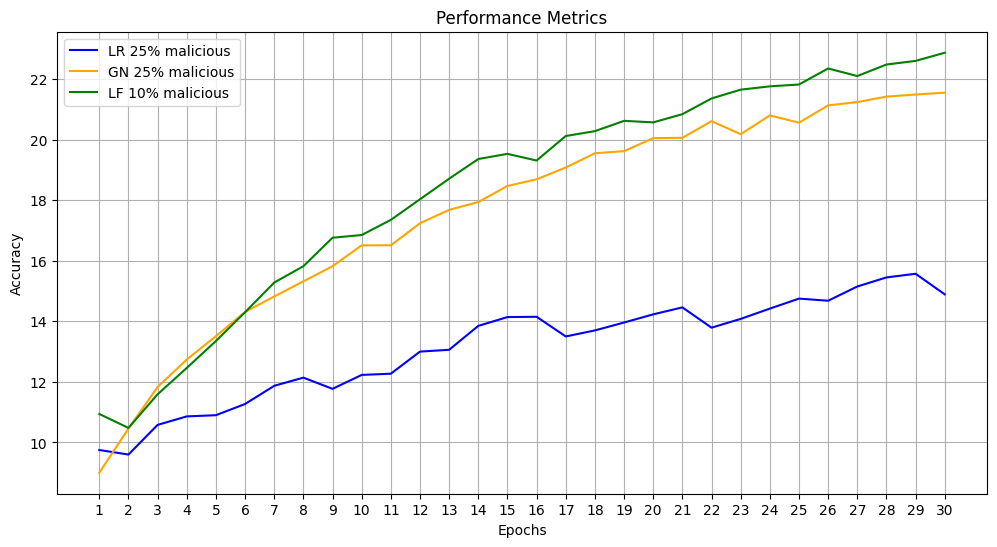

In [107]:
import matplotlib.pyplot as plt

# Data
lr_25 = [9.75, 9.6, 10.58, 10.86, 10.9, 11.27, 11.87, 12.14, 11.77, 12.23, 12.27, 13.0, 
          13.06, 13.85, 14.14, 14.15, 13.5, 13.7, 13.96, 14.23, 14.46, 13.79, 14.08, 
          14.42, 14.75, 14.68, 15.15, 15.45, 15.57, 14.89]
gn_25 = [9.0, 10.46, 11.83, 12.74, 13.51, 14.31, 14.82, 15.32, 15.82, 16.51, 16.51, 
          17.24, 17.68, 17.94, 18.47, 18.69, 19.08, 19.55, 19.62, 20.05, 20.06, 
          20.61, 20.18, 20.8, 20.56, 21.13, 21.24, 21.42, 21.49, 21.55]
lf_10 = [10.94, 10.48, 11.59, 12.46, 13.35, 14.3, 15.28, 15.82, 16.76, 16.85, 
          17.35, 18.03, 18.71, 19.36, 19.53, 19.31, 20.12, 20.28, 20.62, 20.57, 
          20.84, 21.36, 21.65, 21.76, 21.82, 22.35, 22.1, 22.48, 22.6, 22.87]

# X-axis values (assuming they are the same for each)
x = list(range(1, len(lr_25) + 1))

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(x, lr_25, label='LR 25% malicious', color='blue')
plt.plot(x, gn_25, label='GN 25% malicious', color='orange')
plt.plot(x, lf_10, label='LF 10% malicious', color='green')

plt.title('Performance Metrics with FLTrust enabled')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.legend()
plt.grid()

plt.show()


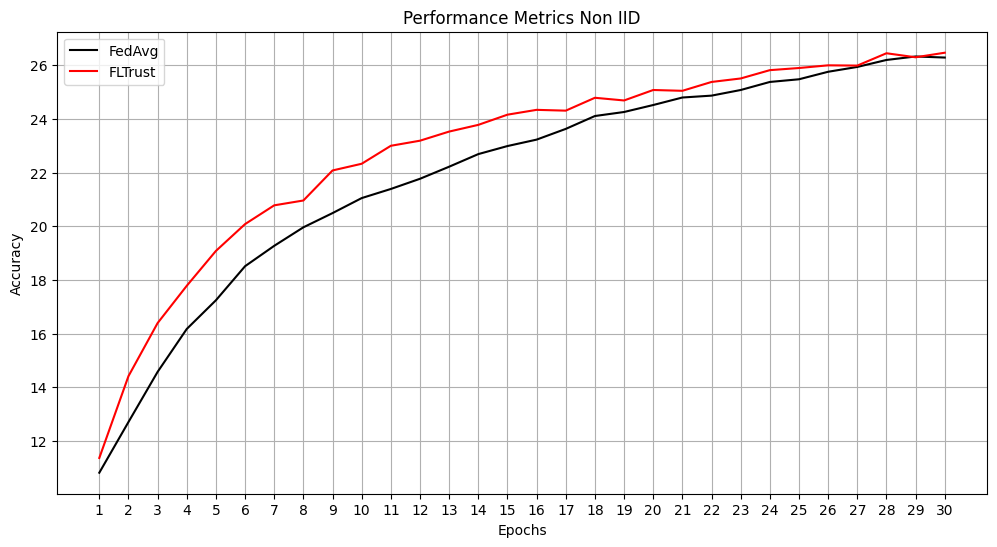

In [117]:
import matplotlib.pyplot as plt

# Data
Fedavg = [10.81, 12.7, 14.57, 16.17, 17.24, 18.51, 19.27, 19.96, 20.49, 21.05, 21.39, 21.77, 22.22, 22.69, 22.99, 23.23, 23.63, 24.11, 24.26, 24.52, 24.8, 24.87, 25.08, 25.38, 25.48, 25.76, 25.94, 26.2, 26.33, 26.29]
FLTrust = [11.36, 14.41, 16.39, 17.78, 19.08, 20.08, 20.78, 20.96, 22.08, 22.33, 23.0, 23.19, 23.53, 23.78, 24.16, 24.34, 24.31, 24.79, 24.69, 25.08, 25.05, 25.38, 25.51, 25.82, 25.9, 26.0, 25.99, 26.45, 26.3, 26.47]

# X-axis values (assuming they are the same for each)
x = list(range(1, len(Fedavg) + 1))

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(x, Fedavg, label='FedAvg', color='black')
plt.plot(x, FLTrust, label='FLTrust', color='red')

plt.title('Performance Metrics Non IID')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.legend()
plt.grid()

plt.show()


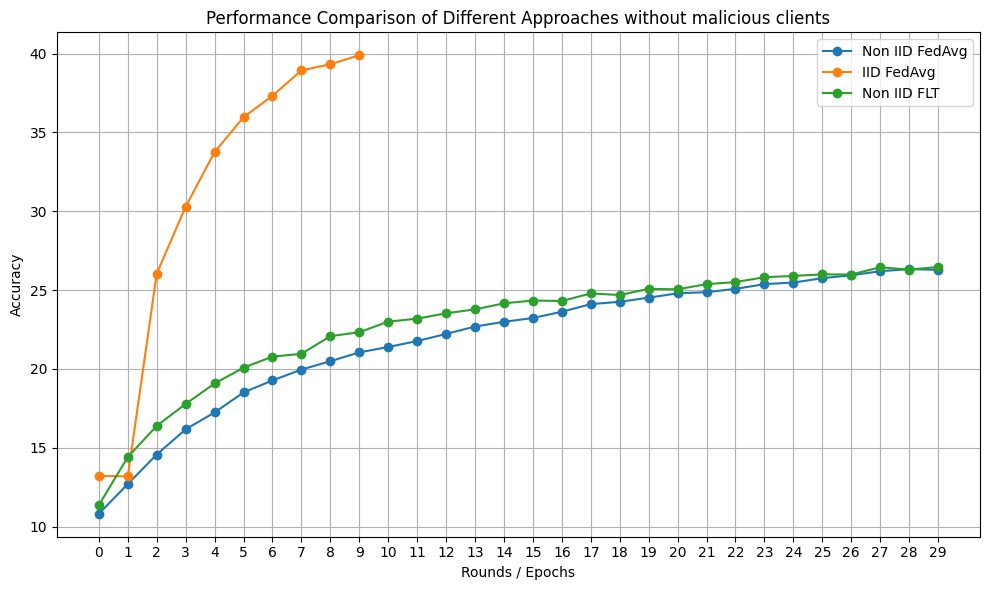

In [116]:
import matplotlib.pyplot as plt

# Data
fed_avg = [10.81, 12.7, 14.57, 16.17, 17.24, 18.51, 19.27, 19.96, 20.49, 21.05,
           21.39, 21.77, 22.22, 22.69, 22.99, 23.23, 23.63, 24.11, 24.26, 24.52,
           24.8, 24.87, 25.08, 25.38, 25.48, 25.76, 25.94, 26.2, 26.33, 26.29]

iid_fed_avg = [13.21, 13.19, 26.05, 30.3, 33.76, 35.97, 37.33, 38.94, 39.33, 39.9]

no_malicious_fltrust = [11.36, 14.41, 16.39, 17.78, 19.08, 20.08, 20.78, 20.96,
                        22.08, 22.33, 23.0, 23.19, 23.53, 23.78, 24.16, 24.34,
                        24.31, 24.79, 24.69, 25.08, 25.05, 25.38, 25.51, 25.82,
                        25.9, 26.0, 25.99, 26.45, 26.3, 26.47]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plotting the data
plt.plot(fed_avg, label='Non IID FedAvg', marker='o')
plt.plot(iid_fed_avg, label='IID FedAvg', marker='o')
plt.plot(no_malicious_fltrust, label='Non IID FLT', marker='o')

# Adding titles and labels
plt.title('Performance Comparison of Different Approaches without malicious clients')
plt.xlabel('Rounds / Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(max(len(fed_avg), len(iid_fed_avg), len(no_malicious_fltrust))))
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()
